In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt

from sklearn.externals import joblib

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.preprocessing import(
    scale,
    LabelEncoder
)
from sklearn.decomposition import PCA

from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)
%matplotlib inline

from sklearn.linear_model import(
    LassoCV
) 

from scipy.stats import skew

In [51]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [52]:
# train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = train.dtypes[train.dtypes != "object"].index

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train[skewed_feats] = np.log1p(train[skewed_feats])

# Getting dummy variables
train_dummies = pd.get_dummies(train)
train_dummies = train_dummies.fillna(train_dummies.mean())

# Splitting train df into train and test data
train_X = train_dummies.loc[:, train_dummies.columns != 'SalePrice']
train_y = train_dummies["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y)

In [112]:

# Calculate RMSE
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 3))
    return(rmse)

model_lasso = LassoCV(normalize=True).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
model_lasso.score(X_test, y_test)

0.92851170392486093

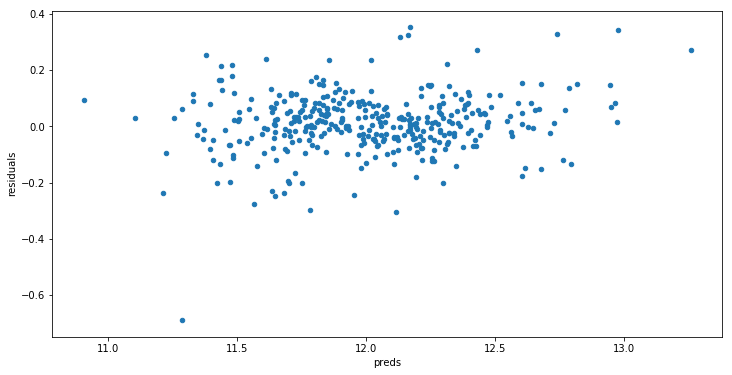

In [113]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [85]:
rf = RandomForestRegressor(max_features=25, n_estimators=500)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.88376068438089317

In [ ]:
# cross_vals = {}
# for i in range(11,12):
#     rf = RandomForestRegressor(max_depth=9, max_features=6, random_state=10, n_estimators=500)
#     cross_val_mean = np.mean(cross_val_score(rf, X_train, y_train, cv=10))
#     cross_vals[str(i)] = cross_val_mean
#     print(f"10-fold cv score mean with max_depth {i}: {cross_val_mean}")

In [ ]:
# grid_search.fit(X_train,y_train)
# rf = RandomForestRegressor()
# parameters = {"max_depth": [9,10,11,12],
#               "min_samples_split" :[2,3,4,5,6],
#               "n_estimators" : [100,500],
#               "max_features": (4,5,6)}
# grid_search = GridSearchCV(rf, parameters, n_jobs=3, cv=5)
#grid_search_CV = joblib.dump(grid_search, "grid_search_dummies.pkl")

In [96]:
# Random Forest Feature-Coefficient Dataframe
# fcdf = pd.DataFrame.from_dict(dict(zip(list(X_train.columns), list(rf.feature_importances_))), orient="index").sort_values(by=0,ascending=False)

In [114]:
# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

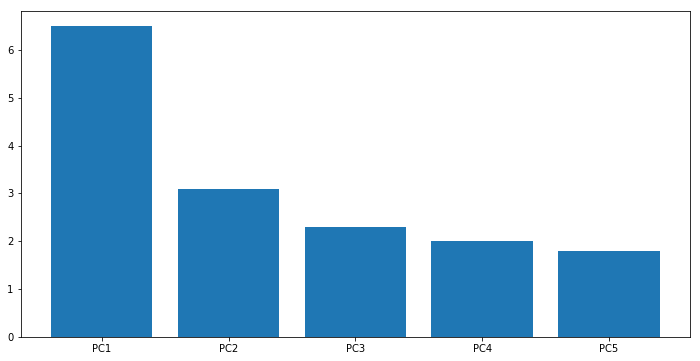

In [115]:
# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


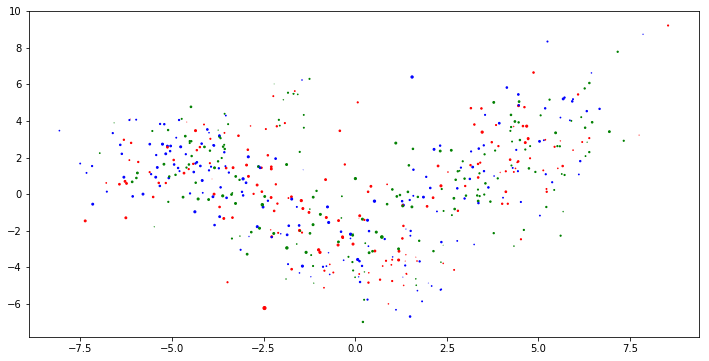

In [116]:
# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])